In [1]:
import tritonclient.http as httpclient
import numpy as np
import sys

In [2]:
sys.path.append('../')

from modelacc import *

In [3]:
client = httpclient.InferenceServerClient(url="localhost:8000")

In [4]:
# test connection
print("client.is_server_live():", client.is_server_live())

client.is_server_live(): True


In [5]:
img_path = get_sample_test_image_path()

# prepare input
input_data = preprocess_image(img_path, target_size=640, transpose=True).astype(np.float32)

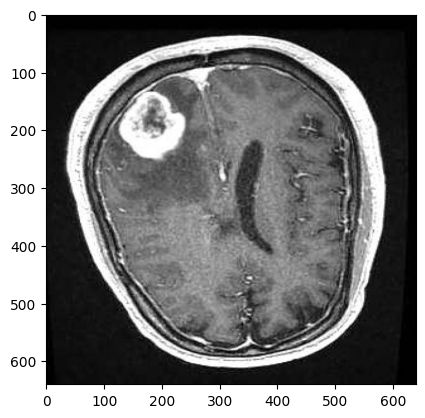

In [6]:
img = Image.open(img_path)
plt.imshow(img)

In [7]:
inputs = httpclient.InferInput("images", input_data.shape, "FP32")
inputs.set_data_from_numpy(input_data)

In [8]:
output0 = httpclient.InferRequestedOutput("output0")
output1 = httpclient.InferRequestedOutput("output1")

In [9]:
response = client.infer(model_name="yolo", inputs=[inputs], outputs=[output0, output1])

In [10]:
output_data0 = response.as_numpy("output0")
output_data1 = response.as_numpy("output1")

In [11]:
print("output_data0.shape:", output_data0.shape)
print("output_data1.shape:", output_data1.shape)

output_data0.shape: (1, 37, 8400)
output_data1.shape: (1, 32, 160, 160)


In [12]:
outputs = [output_data0, output_data1]

In [ ]:
img = Image.open(img_path)
img_width, img_height = img.size
result_image = postprocess_image(
    outputs, img, img_width, img_height, prob_threshold=0.5
)

TypeError: open() missing 1 required positional argument: 'fp'